# *Distracted Driver Detection with CNN - Base*

**The objectives of this project are the following:**
- Implement and train an basic CNN model for distracted driver detection
- Train a model based on a pre-trained model(VGG-19) via transfer learning 
- Evaluate the performance of both models for their loss and accuracy, including training and validation. 
- Load trained models and use it to run classification on test data that the model never seen before.

## Libaries

The main software application being used for this project is *Keras*, including data pre-processing, architecture, model training, training callback functions, and model metrics. *matplotlib* and *seaborn* is also imported for plotting; *os* and *glob* are used for locating and accessing files, etc.  

In [1]:
from keras import layers # layers
from keras import models # models
from keras import optimizers # optimizers for complilation 
from keras import losses # losses 
from keras import metrics # metrics
from keras.utils import plot_model # show the model details in graph

### Callback functions ### 
from keras.callbacks import EarlyStopping  # stop earlier
from keras.callbacks import ReduceLROnPlateau # update the learning rate
from keras.callbacks import ModelCheckpoint # save model,weights

from keras.preprocessing.image import ImageDataGenerator # read images and augumentation
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array
from keras.applications import VGG19
from keras.applications import MobileNet

from PIL import Image
from glob import glob

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import os
import random

In [2]:
# check the version of keras
import keras
print(keras.__version__)

2.4.3


In [3]:
# do i have a GPU available ??? 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Dataset

The dataset was found from *kaggle* at: [https://www.kaggle.com/c/state-farm-distracted-driver-detection/data], which includes labeled driver images; each class is an behavior that was classified, such as, texting, eating, talking on the phone, makeup, reaching behind, etc. It also provides test data that are not labeled, all can be found within same folder.

The 10 classes to predict are:

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger


### Descriptions

The downloaded dataset is a compressed zip package, it includes three part after unzip. 

- imgs: driver pictures will be used, and including train and test as sub-folders.
- driver_imgs_list.csv - csv file that includes the name of driver picturs, subject id(driver), class id(class).
- sample_submission.csv - sample submission file since this is a kaggle competition. (**I WILL NOT USE THIS FILE**)

In [4]:
CURR_DIR = os.getcwd()

DATA_DIR = os.path.join(CURR_DIR, "data/state-farm-distracted-driver-detection/")

TRAIN_DIR = os.path.join(DATA_DIR, "imgs/train")  # train dir has sub-classes folders 
TEST_DIR = os.path.join(DATA_DIR, "imgs/test")    # test data folder

DATA_FILE = os.path.join(DATA_DIR, "driver_imgs_list.csv") # train images and according class and driver

# ensure the folder exist for saving the models
MODEL_DIR = os.path.join(CURR_DIR, "saved_models")

# create the model dir if not exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [5]:
# define the class and its according description 

# classes 
classes = {'c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'}

# {folder name}:{description}
class_dict = {'c0': 'Safe driving', 
              'c1': 'Texting - right', 
              'c2': 'Talking on the phone - right', 
              'c3': 'Texting - left', 
              'c4': 'Talking on the phone - left', 
              'c5': 'Operating the radio', 
              'c6': 'Drinking', 
              'c7': 'Reaching behind', 
              'c8': 'Hair and makeup', 
              'c9': 'Talking to passenger'}

#### Parameters setup 

Before data pre-processing, I will define the input shape(target height and width), and number of training epochs, and the batch size that helps to reduce the memory usage when running on less powerful platforms. 

In [6]:
#INPUT_WIDTH = 32
#INPUT_HEIGHT = 32

INPUT_WIDTH = 64
INPUT_HEIGHT = 64

In [7]:
#EPOCHES = 5
#SIZE = 32

EPOCHES = 50
BATCH_SIZE = 128

#### Data Pre-Processing

With *Keras*, image data processing has become much easier. Instead of reading subfolers for all files, load pictures and covert to numpy array, *Keras* provides API calls, *flow_from_directory*, which will read data from specified directory and categorize to different classes, load with resizing, etc, with the usage of *ImageDataGenerator*.

In [8]:
# with data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.4, 1.2],
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                    classes=None, 
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE, 
                                                    shuffle=True, 
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                         target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                         classes=None, 
                                                         class_mode='categorical',
                                                         batch_size=BATCH_SIZE, 
                                                         shuffle=True, 
                                                         subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                  target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False, 
                                                  class_mode='categorical')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [9]:
# calculate the steps for training and validation
TRAIN_STEPS = train_generator.samples // BATCH_SIZE
VALIDATION_STEPS = validation_generator.samples // BATCH_SIZE

## Basic CNN Architeture 

In [10]:

model = models.Sequential()

# filters, stride, input size, chanel 
model.add(layers.Conv2D(32, (5,5), padding='same', input_shape=(INPUT_HEIGHT, INPUT_WIDTH, 3)))

model.add(layers.BatchNormalization())

model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2,2))) #size: number of filters(32) * height * width 

model.add(layers.Conv2D(64, (5,5), padding='same'))

model.add(layers.BatchNormalization())

model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2,2))) #size: number of filters(64) * height/2 * width/2 

model.add(layers.Conv2D(128, (5,5), padding='same'))

model.add(layers.BatchNormalization())

model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2,2))) #size: number of filters(128) * height/4 * width/4 

model.add(layers.Flatten())

model.add(layers.Dropout(0.2))

model.add(layers.Dense(256))

model.add(layers.BatchNormalization())

model.add(layers.Activation("relu"))

model.add(layers.Dense(10))

model.add(layers.BatchNormalization())

model.add(layers.Activation("softmax"))

In [11]:
# use categorical crossentropy since our data is multi-class classification
#loss_func = losses.CategoricalCrossentropy(from_logits=False, name="categorical_crossentropy")

# outperforms others in practice, RMSprop + Momentum
#opt_func = optimizers.Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

#model.compile(loss=loss_func, 
#              optimizer=opt_func, 
#              metrics=['accuracy'])

In [12]:
# check the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

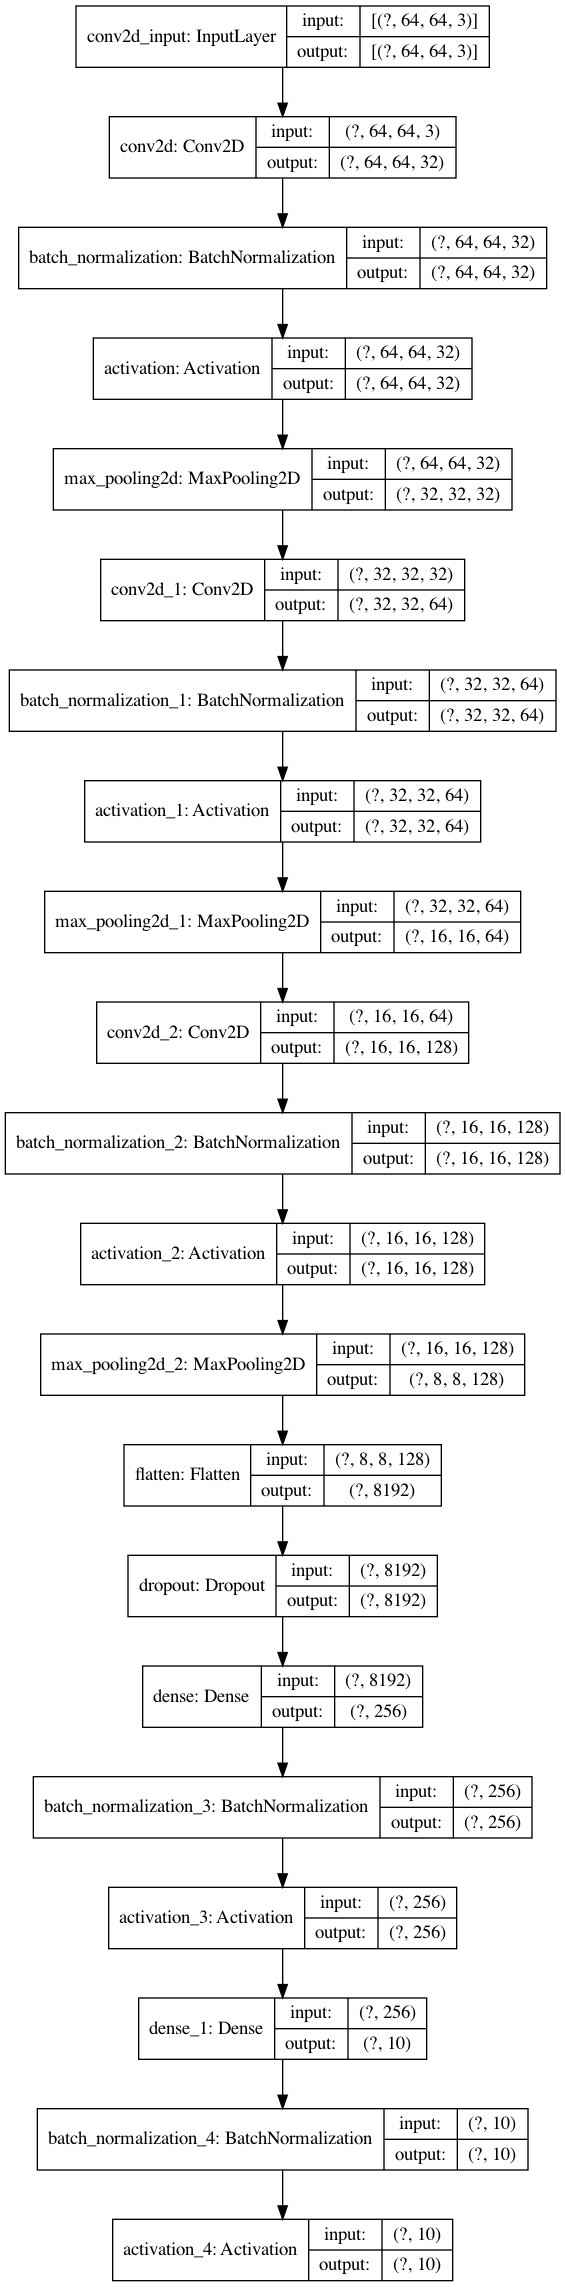

In [13]:
# plot the model in picture format to visualize how layers are connected with according input/output size
plot_model(model, to_file="basic_cnn_model.png", show_shapes=True, show_layer_names=True)

#### Callback functions

Callback functions are provided by *Keras*, which will be executed during the training of the model and can be used for different purposes; In this project, I will use the following three callback APIS:
- EarlyStopping: stop the training earlier if the specified metric stopped improving
- ReduceLROnPlateau: adjust the learning rate when the specified metric stopped improving
- ModelCheckpoint: save the model weights and model each training epoch

In [14]:
# define callback functions
# 1: early stopping 
# https://keras.io/api/callbacks/early_stopping/
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta = 0,
    patience=3,
    mode='min',
    restore_best_weights = True,
    verbose=1
)

# 2: reduce the learning rate when a metric has stopped improving 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # monitored metric
    factor=0.2,   # new lr = factor * lr
    patience=2,   # number of epochs 
    min_lr=0.001,  # min lr
    verbose=1
)

# 3: save model or model weights
# https://keras.io/api/callbacks/model_checkpoint/
model_path = MODEL_DIR + '/distracted_driver_detection_base.h5'
model_cp = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, model_cp]
#callbacks = []

In [15]:
history=model.fit(train_generator, 
                  steps_per_epoch = TRAIN_STEPS, 
                  epochs = EPOCHES,
                  verbose = 1,
                  validation_data = validation_generator,
                  validation_steps = VALIDATION_STEPS,
                  callbacks = callbacks)

Epoch 1/50
140/140 [==============================] - ETA: 0s - loss: 1.9608 - accuracy: 0.2908
Epoch 00001: val_loss improved from inf to 2.47429, saving model to /Users/jacobliu/Documents/GitHub/CS598-deep-learning/TermProject/saved_models/distracted_driver_detection_base.h5
140/140 [==============================] - 174s 1s/step - loss: 1.9608 - accuracy: 0.2908 - val_loss: 2.4743 - val_accuracy: 0.1270
Epoch 2/50
140/140 [==============================] - ETA: 0s - loss: 1.3695 - accuracy: 0.5558
Epoch 00002: val_loss improved from 2.47429 to 2.24191, saving model to /Users/jacobliu/Documents/GitHub/CS598-deep-learning/TermProject/saved_models/distracted_driver_detection_base.h5
140/140 [==============================] - 171s 1s/step - loss: 1.3695 - accuracy: 0.5558 - val_loss: 2.2419 - val_accuracy: 0.1875
Epoch 3/50
140/140 [==============================] - ETA: 0s - loss: 0.9937 - accuracy: 0.7221
Epoch 00003: val_loss improved from 2.24191 to 1.72150, saving model to /Users/j

Epoch 00022: early stopping


## Transfer learning on Pre-Trained Model (VGG-19)

VGG-19 architecture is being used for this experienment. 

In [16]:
conv_base = VGG19(weights="imagenet", 
                  include_top = False, # exclude the top three fully connected layer
                  input_shape = (INPUT_HEIGHT, INPUT_WIDTH, 3), # configure the input shape, default is 224*224*3
                 )

In [17]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [18]:
x = conv_base.output

x = layers.Flatten()(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(256, activation='relu')(x)

predictions = layers.Dense(10, activation='softmax')(x)

In [19]:
t_model= models.Model(inputs=conv_base.input, outputs=predictions)

In [20]:
for layer in conv_base.layers:
    layer.trainable = False

#for layer in t_model.layers[:10]:
#    layer.trainable = False

In [21]:
#t_model.compile(loss='categorical_crossentropy', 
#                #optimizer='adam', 
#                optimizer=optimizers.Adam(lr=0.0001),
#                metrics=['accuracy'])

t_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [22]:
t_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)      

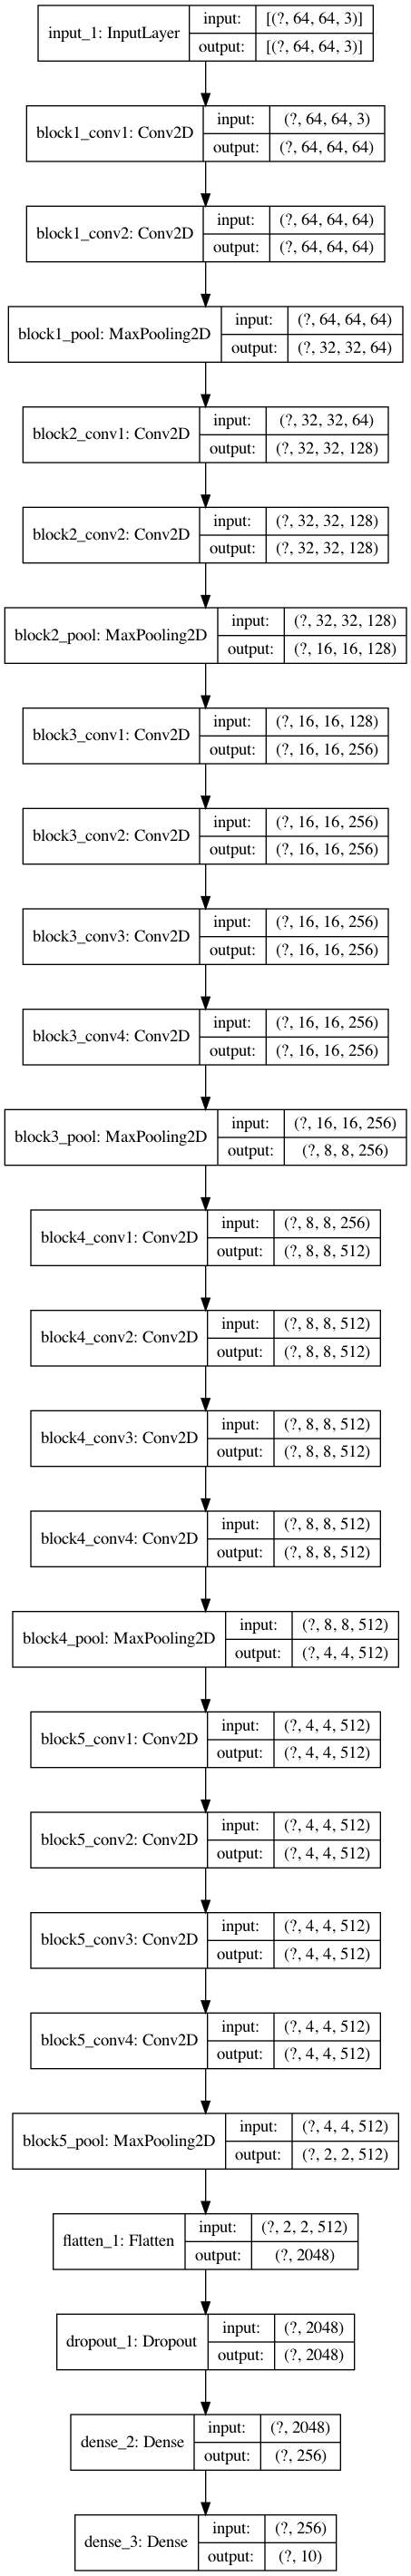

In [23]:
plot_model(t_model, to_file="transfered_model_vgg19.png", show_shapes=True, show_layer_names=True)

In [24]:
t_model_path = MODEL_DIR + '/distracted_driver_detection_vgg19.h5'
model_cp = ModelCheckpoint(
    filepath=t_model_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta = 0,
    patience=3,
    mode='min',
    restore_best_weights = True,
    verbose=1
)

callbacks = [model_cp, early_stop]

In [25]:
# reset data generator
train_generator.reset()
validation_generator.reset()

t_history=t_model.fit(train_generator, 
                      steps_per_epoch = TRAIN_STEPS, 
                      epochs = EPOCHES,
                      verbose = 1,
                      validation_data = validation_generator,
                      validation_steps = VALIDATION_STEPS,
                      callbacks = callbacks)

Epoch 1/50
140/140 [==============================] - ETA: 0s - loss: 2.0630 - accuracy: 0.2540
Epoch 00001: val_loss improved from inf to 1.86379, saving model to /Users/jacobliu/Documents/GitHub/CS598-deep-learning/TermProject/saved_models/distracted_driver_detection_vgg19.h5
140/140 [==============================] - 297s 2s/step - loss: 2.0630 - accuracy: 0.2540 - val_loss: 1.8638 - val_accuracy: 0.3196
Epoch 2/50
140/140 [==============================] - ETA: 0s - loss: 1.8214 - accuracy: 0.3467
Epoch 00002: val_loss improved from 1.86379 to 1.72945, saving model to /Users/jacobliu/Documents/GitHub/CS598-deep-learning/TermProject/saved_models/distracted_driver_detection_vgg19.h5
140/140 [==============================] - 295s 2s/step - loss: 1.8214 - accuracy: 0.3467 - val_loss: 1.7294 - val_accuracy: 0.3911
Epoch 3/50
140/140 [==============================] - ETA: 0s - loss: 1.7434 - accuracy: 0.3825
Epoch 00003: val_loss improved from 1.72945 to 1.65542, saving model to /Users

## Performance Evalution

Performance will be evaluated on losses and accuracy for trainning and validation. The function below is a generic function that can be used to plot either one based on user input. 

In [26]:
def show_metric(history, metric):
    '''
    history: return value of the .fit, which includes all the history while training the model
    metric: which metric to plot
    '''
    train_metrics = history.history[metric]
    validation_metrics = history.history['val_' + metric]
    
    # make it start from 1
    train_epochs = range(1, len(train_metrics) + 1)
    
    sns.set(color_codes=True)
    plt.figure(1, figsize=(8, 6))
    plt.plot(train_epochs, train_metrics)
    plt.plot(train_epochs, validation_metrics)
    
    plt.title('Training and Validation '+ metric)
    
    plt.xlabel("Number of Epochs")
    plt.ylabel(metric)
    
    plt.legend(["Training " + metric, "Validation " + metric])
    plt.show()

    
def plot_confusion_matrix(data, labels):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(8, 6))
 
    plt.title("Confusion Matrix")
     
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
     
    plt.show()

#### Basic CNN Architecture

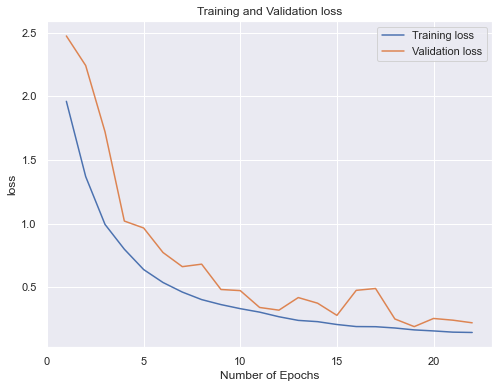

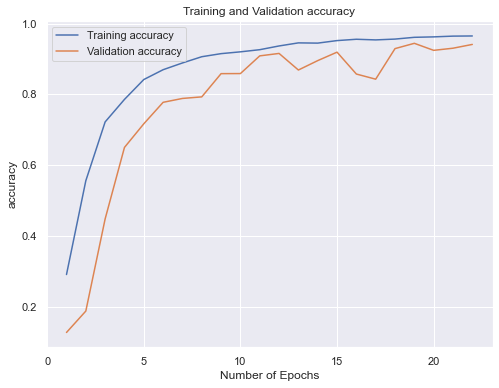

In [27]:
show_metric(history, "loss")
show_metric(history, "accuracy")

In [28]:
test_generator.reset()
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//BATCH_SIZE+1)
print("Loss:",loss)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 706us/step - loss: 0.8585 - accuracy: 0.7500
Loss: 0.8585101962089539
Accuracy: 0.75


Classification Report
              precision    recall  f1-score   support

          c4       0.86      0.60      0.71        10
          c9       0.77      1.00      0.87        10
          c1       0.80      0.80      0.80        10
          c6       0.82      0.90      0.86        10
          c0       0.69      0.90      0.78        10
          c5       0.83      1.00      0.91        10
          c2       1.00      0.60      0.75        10
          c8       0.62      1.00      0.77        10
          c3       0.67      0.40      0.50        10
          c7       0.50      0.30      0.37        10

    accuracy                           0.75       100
   macro avg       0.76      0.75      0.73       100
weighted avg       0.76      0.75      0.73       100



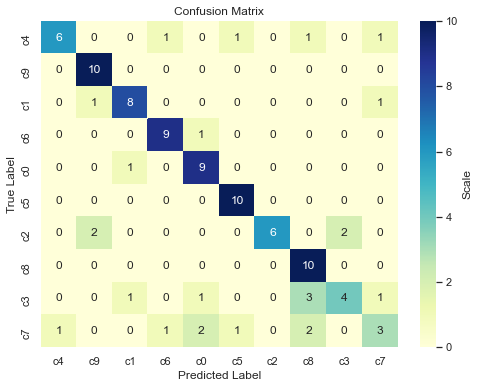

In [29]:
test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples//BATCH_SIZE+1)
preds = np.argmax(preds, axis=1)

cr = classification_report(test_generator.classes, preds, target_names=classes)
print('Classification Report')
print(cr)

cm = confusion_matrix(test_generator.classes, preds)
plot_confusion_matrix(cm, classes)

### Model with transfer learning on pre-trained model

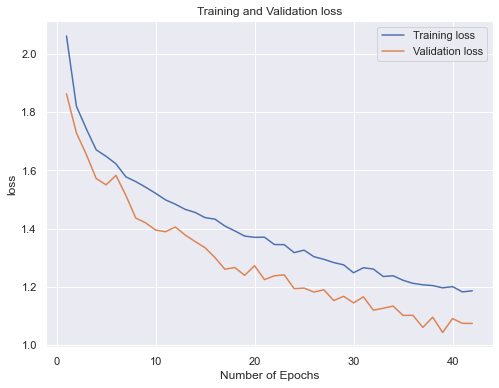

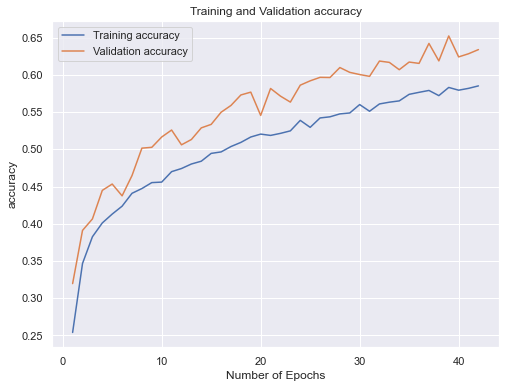

In [30]:
show_metric(t_history, "loss")
show_metric(t_history, "accuracy")

In [31]:
test_generator.reset()
loss, accuracy = t_model.evaluate(test_generator, steps=test_generator.samples//BATCH_SIZE+1)
print("Loss:",loss)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 971us/step - loss: 1.7352 - accuracy: 0.3900
Loss: 1.73518705368042
Accuracy: 0.38999998569488525


Classification Report
              precision    recall  f1-score   support

          c4       0.30      0.30      0.30        10
          c9       0.36      0.40      0.38        10
          c1       0.38      0.30      0.33        10
          c6       0.50      0.10      0.17        10
          c0       0.40      0.40      0.40        10
          c5       1.00      0.80      0.89        10
          c2       0.50      0.20      0.29        10
          c8       0.50      0.70      0.58        10
          c3       0.27      0.30      0.29        10
          c7       0.18      0.40      0.25        10

    accuracy                           0.39       100
   macro avg       0.44      0.39      0.39       100
weighted avg       0.44      0.39      0.39       100



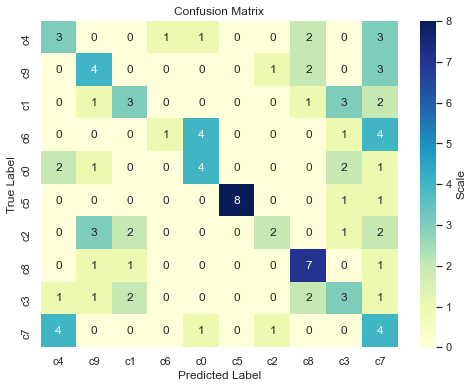

In [32]:
test_generator.reset()
preds = t_model.predict(test_generator, steps=test_generator.samples//BATCH_SIZE+1)
preds = np.argmax(preds, axis=1)

cr = classification_report(test_generator.classes, preds, target_names=classes)
print('Classification Report')
print(cr)

cm = confusion_matrix(test_generator.classes, preds)
plot_confusion_matrix(cm, classes)

## Model verification

In [33]:
def show_test_images(model):
    plt.subplots(figsize=(20, 6))
 
    for i in range(0, 10):              
        plt.subplot(2, 5, i+1)

        choosen_cls=random.choice(os.listdir(TEST_DIR))
        
        path = os.path.join(TEST_DIR, choosen_cls)
        
        choosen_file=random.choice(os.listdir(path))
        
        f_path = os.path.join(path, choosen_file)
        
        image = load_img(path=f_path, target_size=(INPUT_HEIGHT, INPUT_WIDTH))
        input_arr = img_to_array(image)
        input_arr = np.array([input_arr])  # Convert single image to a batch.
        predictions = model.predict(input_arr)
        
        predicted_class = 'c'+str(np.argmax(predictions))
        
        title_str = "Predicted: "+class_dict[predicted_class]
        
        image = mpimg.imread(f_path)
        
        plt.imshow(image)
        plt.title(title_str)
        plt.axis('off')

    plt.show()

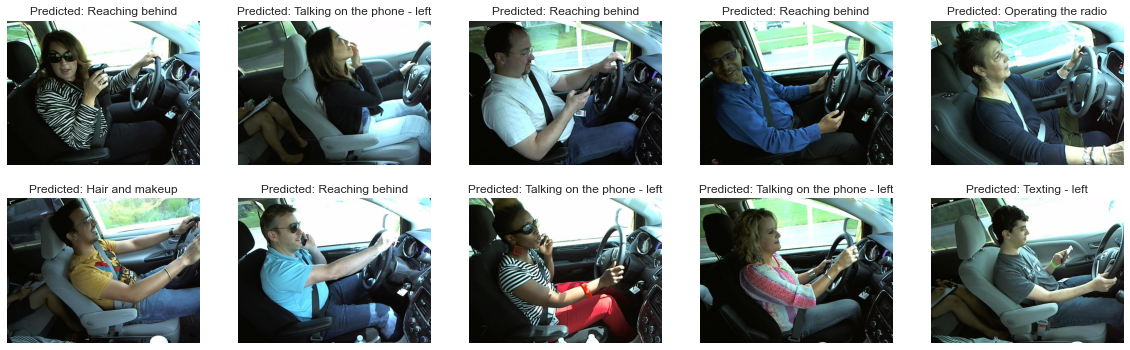

In [34]:
# Load the model
base_model = models.load_model(model_path, compile=True)

show_test_images(base_model)

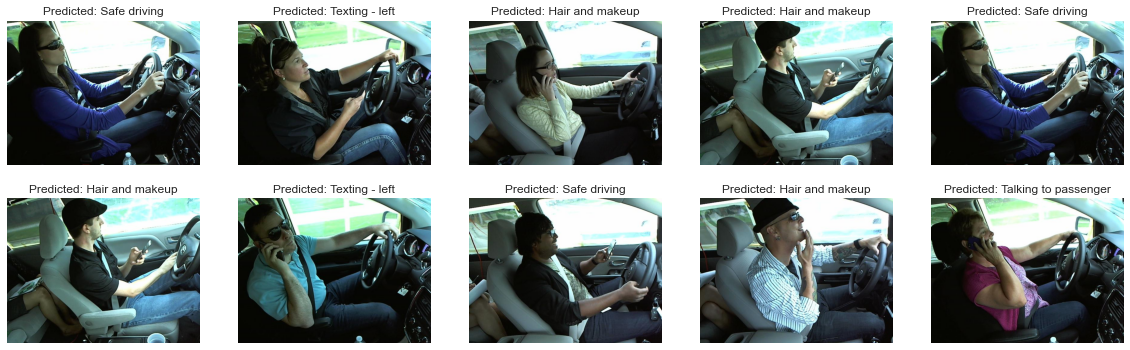

In [35]:
vgg19_model = models.load_model(t_model_path, compile = True)

show_test_images(vgg19_model)

## Reference

Image classification from scratch: https://keras.io/examples/vision/image_classification_from_scratch/

Using Keras Image Data Generator with Transfer Learning: https://becominghuman.ai/using-keras-imagedatagenerator-with-transfer-learning-c4787d430060

Building powerful image classification models using very little data: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Tutorial on using Keras flow_from_directory and generators: https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

Losses: https://keras.io/api/losses/

How to use Callbacks in Keras to Visualize, Monitor and Improve your Deep Learning Model: https://medium.com/iitg-ai/how-to-use-callbacks-in-keras-to-visualize-monitor-and-improve-your-deep-learning-model-c9ca37901b28

Image data preprocessing: https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function

Using Keras Image Data Generator with Transfer Learning: https://becominghuman.ai/using-keras-imagedatagenerator-with-transfer-learning-c4787d430060

A Practical Introduction to Keras Callbacks in TensorFlow 2: https://towardsdatascience.com/a-practical-introduction-to-keras-callbacks-in-tensorflow-2-705d0c584966

4 Pre-Trained CNN Models to Use for Computer Vision with Transfer Learning: https://towardsdatascience.com/4-pre-trained-cnn-models-to-use-for-computer-vision-with-transfer-learning-885cb1b2dfc

Keras Applications: https://keras.io/api/applications/

 A simple example: Confusion Matrix with Keras flow_from_directory.py: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045#file-a-simple-example-confusion-matrix-with-keras-flow_from_directory-py
